# Optimisation of MA Crossover Trading Strategy 


This notebook will discuss how simple technical indicators (TI) can be profitable when used in the right market condition. For example, the MA crossover strategy usually performs well in trending markets and with enough optimisation it can beat buy and hold strategies. 

For this notebook we will go through methods on how to backtest a simple moving average crossover strategy and optimising it for a given set of dates.
We'll also keep track of of the sharpe ratio to get a full picture of risk to return associated with the strategy.



In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as data
import matplotlib.pyplot as plt


In [56]:
#get the ticker data from yahoo
ticker_data=data.DataReader('BTC-USD','yahoo',start='01/01/2016', end='01/01/2020')
ticker_data.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600,431.959991


- Choose any random long and short MA parameters

In [57]:
#set the short and long sma and add the calculate columns to the dataframe
shortma=50
longma=200
ticker_data['short sma']=np.round(ticker_data['Adj Close'].rolling(window=shortma).mean(),2)# the 2 is to round t 2 decimal point
ticker_data['long sma']=np.round(ticker_data['Adj Close'].rolling(window=longma).mean(),2)
ticker_data.tail()

,High,Low,Open,Close,Volume,Adj Close,short sma,long sma
Date,,,,,,,,
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257701,7422.652832,7594.04,9321.27
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131671,7292.995117,7558.78,9316.58
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.50,9309.08
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,18565664996,7200.174316,7495.19,9300.89
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,20802083465,6985.470215,7458.74,9290.84


Create a new column for the difference between the long ma and short, this is to help us see where the MA crossover are occurring.

- When the integer is positive it means the short ma is above the long ma signifying that we are in a long position. When the long ma is above the short ma, the integer will be negative signifying that we are in a short position.

In [58]:
ticker_data['short_ma - long_ma']= ticker_data['short sma']-ticker_data['long sma']
ticker_data.tail()

,High,Low,Open,Close,Volume,Adj Close,short sma,long sma,short_ma - long_ma
Date,,,,,,,,,
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257701,7422.652832,7594.04,9321.27,-1727.23
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131671,7292.995117,7558.78,9316.58,-1757.80
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.50,9309.08,-1781.58
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,18565664996,7200.174316,7495.19,9300.89,-1805.70
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,20802083465,6985.470215,7458.74,9290.84,-1832.10


In this section we can add further definitions to indicate when the signal should be valid.

- i.e when the crossover occurs how long should we wait until we enter or exit the market, depending on the signal. 

This method is used to avoid the multiple crossover that may occur before the trend  becomes clear.

We will use the spread between the short ma and long ma to signify a clear trend. For this example we will use a spread of 50 between the two MA to indicate a clear trend has developed hence execute a trade.

The Stance will indicate whether you are long or short the market based on the sign (-1 short  , 1 Long , 0 neutral)

In [59]:
#create a new column 'stance' and assign a 1 or -1 to wherever the spread 
#between the two MA is over 50 or under 50


# X=50
# Y=-50
X=0
Y=0
ticker_data['Stance']=np.where(ticker_data['short_ma - long_ma'] > X,1,0)
ticker_data['Stance']=np.where(ticker_data['short_ma - long_ma'] < Y,-1,ticker_data['Stance'])
#remove all the NaN values
ticker_data=ticker_data.dropna()
ticker_data

,High,Low,Open,Close,Volume,Adj Close,short sma,long sma,short_ma - long_ma,Stance
Date,,,,,,,,,,
2016-07-17,681.554993,668.625000,679.809021,673.106018,69465000,673.106018,646.61,479.96,166.65,1
2016-07-18,673.276978,667.632019,672.737976,672.864014,61203300,672.864014,649.39,481.15,168.24,1
2016-07-19,672.929016,663.359985,672.806030,665.684998,94636400,665.684998,652.07,482.31,169.76,1
2016-07-20,666.218994,660.414978,665.228027,665.012024,60491800,665.012024,654.63,483.49,171.14,1
2016-07-21,666.583008,646.721985,664.921997,650.619019,134169000,650.619019,656.89,484.58,172.31,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257701,7422.652832,7594.04,9321.27,-1727.23,-1
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131671,7292.995117,7558.78,9316.58,-1757.80,-1
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.50,9309.08,-1781.58,-1


In [60]:
#compare how many days cumulitively we will be long, short based on this historical dataset
ticker_data['Stance'].value_counts()


 1    805
-1    459
Name: Stance, dtype: int64

### Strategy backtester 

In order to get insight to how the trades are developing, we will work out the daily returns of the market and the strategy itself. 

The daily percentage returns are worked out by taking current price minus previous price divided by current price multiplied by 100. This will yield the increase on that day in terms of percentage.

In order to build the MA strategy backtester, we will multiply the daily returns by the stance column to capture the performance. 

<!-- The best thing about this is that as if the strategy dictates that we go short, and the market actualy goes down, the negative return multiplied by the negative stance will yield a positive return; And if the strategy dictates that we go 
long then and market goes down , the negative log returns multiplied by the positive stance will yield a negative return.

So the signs have been taken care of already -->





In [61]:
#create a column for the log percentage daily returns 
#
# ticker_data['dailyreturns']=np.log(ticker_data['Adj Close']/ticker_data['Adj Close'].shift(1))

ticker_data['daily_returns']=ticker_data['Adj Close'].pct_change()

#create a column for the log percentage return for the strategy
ticker_data['Strategy_returns']=ticker_data['daily_returns']*ticker_data['Stance']

ticker_data.head(200)

,High,Low,Open,Close,Volume,Adj Close,short sma,long sma,short_ma - long_ma,Stance,daily_returns,Strategy_returns
Date,,,,,,,,,,,,
2016-07-17,681.554993,668.625000,679.809021,673.106018,69465000,673.106018,646.61,479.96,166.65,1,NaN,NaN
2016-07-18,673.276978,667.632019,672.737976,672.864014,61203300,672.864014,649.39,481.15,168.24,1,-0.000360,-0.000360
2016-07-19,672.929016,663.359985,672.806030,665.684998,94636400,665.684998,652.07,482.31,169.76,1,-0.010669,-0.010669
2016-07-20,666.218994,660.414978,665.228027,665.012024,60491800,665.012024,654.63,483.49,171.14,1,-0.001011,-0.001011
2016-07-21,666.583008,646.721985,664.921997,650.619019,134169000,650.619019,656.89,484.58,172.31,1,-0.021643,-0.021643
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-29,923.418030,919.148010,922.067017,919.495972,60851700,919.495972,889.05,709.41,179.64,1,-0.002272,-0.002272
2017-01-30,923.047974,919.473999,920.151001,920.382019,78227296,920.382019,892.06,710.72,181.34,1,0.000964,0.000964
2017-01-31,972.018982,920.958984,920.958984,970.403015,164582000,970.403015,895.87,712.26,183.61,1,0.054348,0.054348


In [62]:
ticker_data['Strategy_returns'].describe()

count    1263.000000
mean        0.003060
std         0.040953
min        -0.187411
25%        -0.012382
50%         0.001765
75%         0.020527
max         0.252472
Name: Strategy_returns, dtype: float64

In [63]:
ticker_data['daily_returns'].describe()

count    1263.000000
mean        0.002689
std         0.040979
min        -0.187411
25%        -0.013009
50%         0.002082
75%         0.018977
max         0.252472
Name: daily_returns, dtype: float64

 When we compare the standard deviation of the daily strategy and daily returns we cannot seem to get a lot of information out as they are very similar. For this reason we decided to compare the portfolio returns of the two strategies.

In [64]:
#drop the NAN values
ticker_data=ticker_data.dropna()


- In this section we will take the daily percentage change of the stock and the strategy and add 1 to every row.


In [65]:
#add 1 to daily returns
ticker_data['daily_returns']=ticker_data['daily_returns'].apply(lambda x: x+1)
#add 1 to strategy returns
ticker_data['Strategy_returns']=ticker_data['Strategy_returns'].apply(lambda x: x+1)

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [66]:
ticker_data.tail()

,High,Low,Open,Close,Volume,Adj Close,short sma,long sma,short_ma - long_ma,Stance,daily_returns,Strategy_returns
Date,,,,,,,,,,,,
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257701,7422.652832,7594.04,9321.27,-1727.23,-1,1.014302,0.985698
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131671,7292.995117,7558.78,9316.58,-1757.80,-1,0.982532,1.017468
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.50,9309.08,-1781.58,-1,0.986371,1.013629
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,18565664996,7200.174316,7495.19,9300.89,-1805.70,-1,1.000914,0.999086
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,20802083465,6985.470215,7458.74,9290.84,-1832.10,-1,0.970181,1.029819


Now we can compare the buy and hold strategy vs the MA crossover by calculating the cumulative product of the daily returns from the start to end date. This will give us an insight to how well we would have performed between the given dates.

In [67]:
#buy and hold strategy
ticker_data['Buy and hold returns']=ticker_data['daily_returns'].cumprod()
# MA crossover strategy
ticker_data['MA crossover strategy returns']=ticker_data['Strategy_returns'].cumprod()

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\a\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [68]:
ticker_data.tail()


,High,Low,Open,Close,Volume,Adj Close,short sma,long sma,short_ma - long_ma,Stance,daily_returns,Strategy_returns,Buy and hold returns,MA crossover strategy returns
Date,,,,,,,,,,,,,,
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257701,7422.652832,7594.04,9321.27,-1727.23,-1,1.014302,0.985698,11.027465,15.601535
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131671,7292.995117,7558.78,9316.58,-1757.80,-1,0.982532,1.017468,10.834839,15.874060
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.50,9309.08,-1781.58,-1,0.986371,1.013629,10.687171,16.090407
2020-01-01,7254.330566,7174.944336,7194.892090,7200.174316,18565664996,7200.174316,7495.19,9300.89,-1805.70,-1,1.000914,0.999086,10.696939,16.075700
2020-01-02,7212.155273,6935.270020,7202.551270,6985.470215,20802083465,6985.470215,7458.74,9290.84,-1832.10,-1,0.970181,1.029819,10.377964,16.555066


The tail results of the two strategies give us an indication of how the performance compares to each other by the end date.

The MA crossover strategy outperforms the buy and hold strategy by a factor of six.

These results only show the final result and should not be the conclusive findings. We would have to do more analysis by factoring other metrics such as volatility (risk) to know which strategy is better overall.



# Sharpe ratio 

The sharpe ratio metric gives insight to how much returns we get per unit of volatility (the return you get per unit of risk). This is calculated by dividing the returns by standard deviation. The strategy with the highest sharpe ratio is the most desirable as it has the most sensible risk-adjusted returns.


***The risk as mentioned earlier is the standard deviation of the returns.*

In [69]:
daily_returns=ticker_data['daily_returns'].apply(lambda x: x-1)
daily_returns.describe()

count    1263.000000
mean        0.002689
std         0.040979
min        -0.187411
25%        -0.013009
50%         0.002082
75%         0.018977
max         0.252472
Name: daily_returns, dtype: float64

In [70]:
strat_returns=ticker_data['Strategy_returns'].apply(lambda x: x-1)
strat_returns.describe()

count    1263.000000
mean        0.003060
std         0.040953
min        -0.187411
25%        -0.012382
50%         0.001765
75%         0.020527
max         0.252472
Name: Strategy_returns, dtype: float64

 When we compare the standard deviation of the two strategies we cannot seem to get a lot of information out as they are very similar. For this reason we decided to compare the portfolio performance of the two strategies.
 
##### Portfolio performance

In [73]:
BuyAndHold=ticker_data['Buy and hold returns'].describe()
BuyAndHold

count    1263.000000
mean        8.294724
std         5.651811
min         0.813341
25%         3.334505
50%         8.569660
75%        12.162676
max        28.966314
Name: Buy and hold returns, dtype: float64

In [74]:
MACrossover=ticker_data['MA crossover strategy returns'].describe()
MACrossover

count    1263.000000
mean        9.397236
std         6.093653
min         0.813341
25%         3.334505
50%         9.660398
75%        13.966366
max        28.966314
Name: MA crossover strategy returns, dtype: float64

The mean and the standard deviation are pretty much the same for both individual strategies performance, signifying that the data is skewed on both cases. We will plot the results just to make sure.




(array([831., 208., 124., 271., 183., 110.,  19.,  20.,  12.,   6.]),
 array([ 0.89409878,  9.0864069 , 17.27871502, 25.47102314, 33.66333126,
        41.85563937, 50.04794749, 58.24025561, 66.43256373, 74.62487185,
        82.81717997]),
 <a list of 10 Patch objects>)

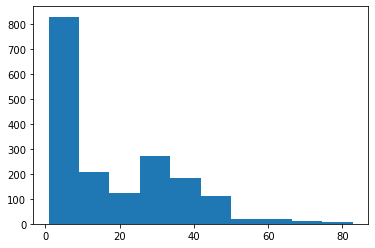

In [384]:
plt.hist(ticker_data['Buy and hold returns'])

(array([924.,  83.,  78., 257., 103., 125., 105.,  63.,  33.,  13.]),
 array([ 0.54077506,  7.47807137, 14.41536768, 21.35266399, 28.2899603 ,
        35.22725661, 42.16455293, 49.10184924, 56.03914555, 62.97644186,
        69.91373817]),
 <a list of 10 Patch objects>)

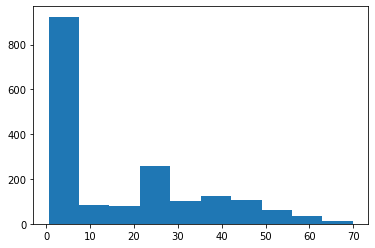

In [385]:
plt.hist(ticker_data['MA crossover strategy returns'])

### Annualised sharpe ratio 

Here we will quickly make a function that calculates the anualised sharpe ratio. This is to get an understanding of how volatile the two strategies are annualy.


In [132]:
#create a function for the annualised sharpe ratio (risk free rate not included!)

def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean()/returns.std())

In [133]:
#annualised sharpe ratio for buy and hold strategy
print('Sharpe ratio for Buy and hold strategy:',annualised_sharpe(ticker_data['daily_returns'].apply(lambda x: x-1)))

Sharpe ratio for Buy and hold strategy: 1.0414995850482722


In [134]:
#annualised sharpe ratio for MA Crossover strategy
print('Sharpe ratio for MA Crossover strategy:' ,annualised_sharpe(ticker_data['Strategy_returns'].apply(lambda x: x-1)))

Sharpe ratio for MA Crossover strategy: 1.1861982641502096


We can see that the MA Crossover strategy performs better than the buy and hold. Although, the improvements are very little we still have managed to reduce the risk of a buy and hold strategy by adopting the MA Crossover strategy 

### Quick plot

Visual plot of the portfolio returns of the two strategies, with the MA crossover and buy and sell signals.

Text(0, 0.5, 'Portfolio performance (hundred %) ')

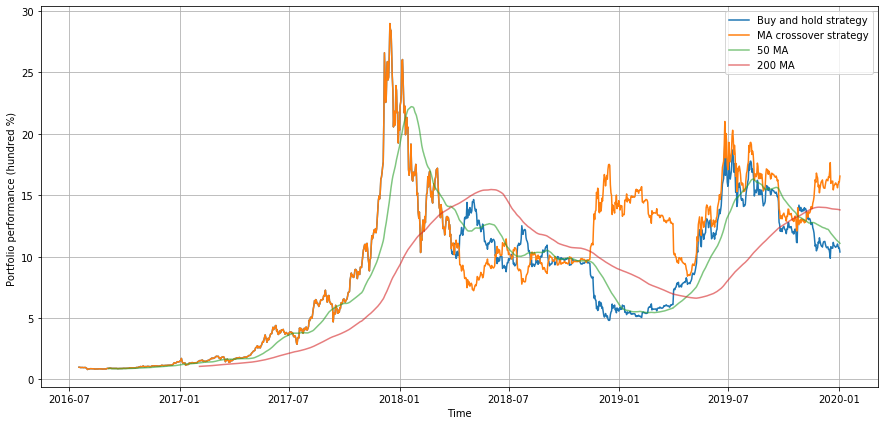

In [145]:
plt.subplots(figsize=(15,7))
#Strategies
plt.plot(ticker_data['Buy and hold returns'],label='Buy and hold strategy')
plt.plot(ticker_data['MA crossover strategy returns'],label='MA crossover strategy')

#MA crossovers
plt.plot(ticker_data['Buy and hold returns'].rolling(50).mean(),alpha=0.60,label='50 MA')
plt.plot(ticker_data['Buy and hold returns'].rolling(200).mean(),alpha=0.60, label='200 MA')

plt.grid()
plt.legend()

plt.xlabel('Time')
plt.ylabel('Portfolio performance (hundred %) ')

# portfolio performance is measured in hundred % increase/decrease




### Summary 

- The MA crossover strategy certainly performs better than buy and hold strategy as end date returns and sharpe ratio are greater. 



# Strategy optimisation 

##### Set up

At this stage, we have already found out what the MA crossover strategy yields more returns for the given ticker in the given date range. 

For this section the key objective is to optimise the long ma and short ma parameters for maximum performance.

The linspace function allows us to make a range of values that we want to test for our optimisation.  

In [148]:
#We wil use linspace to create values that we want to test for
#The first two numbers are the range e.g 10-80 for short ma and last number we pass is the number of increaments we want 
#for the given range

#e.g range of 10-80 with 25 increaments within range
short_ma=np.linspace(10,80,25, dtype=np.int64)

long_ma=np.linspace(150,270,25, dtype=np.int64)

short_ma

array([10, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 47, 50, 53, 56,
       59, 62, 65, 68, 71, 74, 77, 80], dtype=int64)

In [149]:
#make a list array of all the numbers we want to include in the test using
#the linspace function
#you first have to define the starting point, the finishing point and 
#lastly the ammount of points we want to test between the starting and 
#finshing points

short_ma=np.linspace(10,100,40, dtype=int)
long_ma=np.linspace(120,280,40, dtype=int)
short_ma
long_ma


array([120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 161, 165, 169,
       173, 177, 181, 185, 189, 193, 197, 202, 206, 210, 214, 218, 222,
       226, 230, 234, 238, 243, 247, 251, 255, 259, 263, 267, 271, 275,
       280])

Now we can construct two numpy arrays that will hold the results of backtest iterations, one for the pnl and the other for the sharpe ratio.. 

It is important to note that this ends up being a 2D array as we are passing two, one dimensional arrays.

In [150]:
results_pnl=np.zeros((len(short_ma),len(long_ma)))
results_sharpe=np.zeros((len(short_ma),len(long_ma)))         
results_pnl

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Optimisation section

This may be considered the main part of the optimisation as we will iterate through the different combinations to see how they perform in terms returns and sharpe ratio.

We have combined all the previous steps to one function so it is easier to run it in one go.

In [152]:
#create a function for the annualised sharpe ratio (risk free rate not included)

def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean()/returns.std())

- We will make a list array of all the different combination of short_ma and long _ma we want to test for

In [156]:
#you first have to define the starting point, the finishing point and 
#the ammount of points we want to test inbetween


short_ma=np.linspace(10,100,40, dtype=int)
long_ma=np.linspace(120,280,40, dtype=int)

results_pnl=np.zeros((len(short_ma),len(long_ma)))
results_sharpe=np.zeros((len(short_ma),len(long_ma))) 

- The following function will grab the ticker data and compute the end date returns and annualised sharpe ratio.

In [157]:
#The inputs are the ticker name, shortma value and long ma value

#e.g BTC-USD, 50 moving average, 200 moving average

def ma_strategy(ticker_data,short_ma,long_ma):
     #read in data from Yahoo Finance for the relevant ticker
    ticker=data.DataReader(ticker_data,'yahoo',start='01/01/2016',end='01/01/2020')
    
    ticker['short sma']=np.round(ticker['Close'].rolling(window=short_ma).mean(),2)
    ticker['long sma']=np.round(ticker['Close'].rolling(window=long_ma).mean(),2)
    
    #create column with moving average spread differen
    ticker['short_ma - long_ma']= ticker['short sma']-ticker['long sma']
    
    #set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
    X=0
    # Y=-50
    ticker['Stance']=np.where(ticker['short_ma - long_ma'] > X,1,0)
    ticker['Stance']=np.where(ticker['short_ma - long_ma'] < -X,-1,ticker['Stance'])
    #remove all the NaN values
    ticker=ticker.dropna()
    print(ticker['Stance'].value_counts())
    
    #create a column for the log percentage daily returns 
    ticker['Market returns']=ticker['Adj Close'].pct_change()
    #create a column for the log percentage return for the strategy
    ticker['Strategy_returns']=ticker['Market returns']*ticker['Stance']
    ticker=ticker.dropna()
    
    
    #add 1 to daily returns
    ticker['Market returns']=ticker['Market returns'].apply(lambda x: x+1)
    #add 1 to strategy returns
    ticker['Strategy_returns']=ticker['Strategy_returns'].apply(lambda x: x+1)
    
    
    #buy and hold strategy
    ticker['Buy and hold performance']=ticker['Market returns'].cumprod()
    # MA crossover strategy
    ticker['MA crossover strategy performance']=ticker['Strategy_returns'].cumprod()
    
    
    sharpe=annualised_sharpe(ticker['Strategy_returns'].apply(lambda x: x-1))
    
    #Results=ticker['Strategy log returns'].cumsum()[-1],sharpe_strategy
    
    return (ticker['MA crossover strategy performance'][-1],sharpe) #pnl and sharpe


In this section we will call the ma_strategy to make our ticker dataset and will iterate through all the combination outlined for the short and long ma.

We will save the results at each round so we can use it to plot the results.


- For the given combination use i and j (used as indexes here) to refer to the short_ma and long_ma combinations 

- Pass the ticker name, shortma and longma values as input parameter to the ma_strategy function to get the strategy performance and sharpe ratio for the given combination

- Save results at each round for every combination passed as 2d array

*we are calculating many combination so it may take some time to compute*


In [158]:

for i,shortma in enumerate(short_ma):
    for j,longma in enumerate(long_ma):
        pnl, sharpe= ma_strategy('BTC-USD',shortma,longma)
        results_pnl[i,j]=pnl
        results_sharpe[i,j]=sharpe
    

 1    807
-1    537
Name: Stance, dtype: int64
 1    807
-1    533
Name: Stance, dtype: int64
 1    809
-1    527
Name: Stance, dtype: int64
 1    813
-1    519
Name: Stance, dtype: int64
 1    814
-1    514
Name: Stance, dtype: int64
 1    823
-1    501
Name: Stance, dtype: int64
 1    823
-1    497
Name: Stance, dtype: int64
 1    820
-1    496
Name: Stance, dtype: int64
 1    819
-1    493
Name: Stance, dtype: int64
 1    815
-1    493
Name: Stance, dtype: int64
 1    811
-1    492
Name: Stance, dtype: int64
 1    804
-1    495
Name: Stance, dtype: int64
 1    803
-1    492
Name: Stance, dtype: int64
 1    799
-1    492
Name: Stance, dtype: int64
 1    796
-1    491
Name: Stance, dtype: int64
 1    793
-1    490
Name: Stance, dtype: int64
 1    790
-1    489
Name: Stance, dtype: int64
 1    789
-1    486
Name: Stance, dtype: int64
 1    788
-1    483
Name: Stance, dtype: int64
 1    789
-1    478
Name: Stance, dtype: int64
 1    790
-1    472
Name: Stance, dtype: int64
 1    787
-1 

 1    807
-1    476
Name: Stance, dtype: int64
 1    804
-1    475
Name: Stance, dtype: int64
 1    801
-1    474
Name: Stance, dtype: int64
 1    798
-1    473
Name: Stance, dtype: int64
 1    795
-1    472
Name: Stance, dtype: int64
 1    790
-1    472
Name: Stance, dtype: int64
 1    788
-1    470
Name: Stance, dtype: int64
 1    788
-1    466
Name: Stance, dtype: int64
 1    789
-1    461
Name: Stance, dtype: int64
 1    789
-1    457
Name: Stance, dtype: int64
 1    790
-1    452
Name: Stance, dtype: int64
 1    792
-1    446
Name: Stance, dtype: int64
 1    796
-1    438
Name: Stance, dtype: int64
 1    799
-1    431
Name: Stance, dtype: int64
 1    800
-1    426
Name: Stance, dtype: int64
 1    803
-1    418
Name: Stance, dtype: int64
 1    802
-1    415
Name: Stance, dtype: int64
 1    802
-1    411
Name: Stance, dtype: int64
 1    800
-1    409
Name: Stance, dtype: int64
 1    799
-1    406
Name: Stance, dtype: int64
 1    799
-1    402
Name: Stance, dtype: int64
 1    797
-1 

 1    801
-1    425
Name: Stance, dtype: int64
 1    796
-1    425
Name: Stance, dtype: int64
 1    794
-1    423
Name: Stance, dtype: int64
 1    789
-1    424
Name: Stance, dtype: int64
 1    787
-1    422
Name: Stance, dtype: int64
 1    794
-1    411
Name: Stance, dtype: int64
 1    794
-1    407
Name: Stance, dtype: int64
 1    793
-1    404
Name: Stance, dtype: int64
 1    793
-1    400
Name: Stance, dtype: int64
 1    792
-1    397
Name: Stance, dtype: int64
 1    790
-1    394
Name: Stance, dtype: int64
 1    789
-1    555
Name: Stance, dtype: int64
 1    787
-1    553
Name: Stance, dtype: int64
 1    781
-1    555
Name: Stance, dtype: int64
 1    782
-1    550
Name: Stance, dtype: int64
 1    792
-1    536
Name: Stance, dtype: int64
 1    801
-1    523
Name: Stance, dtype: int64
 1    802
-1    518
Name: Stance, dtype: int64
 1    814
-1    502
Name: Stance, dtype: int64
 1    811
-1    501
Name: Stance, dtype: int64
 1    810
-1    498
Name: Stance, dtype: int64
 1    807
-1 

 1    788
-1    540
Name: Stance, dtype: int64
 1    790
-1    534
Name: Stance, dtype: int64
 1    795
-1    525
Name: Stance, dtype: int64
 1    810
-1    506
Name: Stance, dtype: int64
 1    819
-1    493
Name: Stance, dtype: int64
 1    816
-1    492
Name: Stance, dtype: int64
 1    814
-1    489
Name: Stance, dtype: int64
 1    814
-1    485
Name: Stance, dtype: int64
 1    813
-1    482
Name: Stance, dtype: int64
 1    810
-1    481
Name: Stance, dtype: int64
 1    809
-1    478
Name: Stance, dtype: int64
 1    809
-1    474
Name: Stance, dtype: int64
 1    813
-1    466
Name: Stance, dtype: int64
 1    812
-1    463
Name: Stance, dtype: int64
 1    810
-1    461
Name: Stance, dtype: int64
 1    807
-1    460
Name: Stance, dtype: int64
 1    803
-1    459
Name: Stance, dtype: int64
 1    800
-1    458
Name: Stance, dtype: int64
 1    797
-1    457
Name: Stance, dtype: int64
 1    794
-1    456
Name: Stance, dtype: int64
 1    791
-1    455
Name: Stance, dtype: int64
 1    789
-1 

 1    806
-1    461
Name: Stance, dtype: int64
 1    805
-1    457
Name: Stance, dtype: int64
 1    804
-1    454
Name: Stance, dtype: int64
 1    803
-1    451
Name: Stance, dtype: int64
 1    801
-1    449
Name: Stance, dtype: int64
 1    799
-1    447
Name: Stance, dtype: int64
 1    796
-1    446
Name: Stance, dtype: int64
 1    794
-1    444
Name: Stance, dtype: int64
 1    791
-1    443
Name: Stance, dtype: int64
 1    789
-1    441
Name: Stance, dtype: int64
 1    788
-1    438
Name: Stance, dtype: int64
 1    790
-1    431
Name: Stance, dtype: int64
 1    789
-1    428
Name: Stance, dtype: int64
 1    789
-1    424
Name: Stance, dtype: int64
 1    788
-1    421
Name: Stance, dtype: int64
 1    786
-1    419
Name: Stance, dtype: int64
 1    785
-1    416
Name: Stance, dtype: int64
 1    783
-1    414
Name: Stance, dtype: int64
 1    783
-1    410
Name: Stance, dtype: int64
 1    781
-1    408
Name: Stance, dtype: int64
 1    780
-1    404
Name: Stance, dtype: int64
 1    810
-1 

 1    786
-1    419
Name: Stance, dtype: int64
 1    788
-1    413
Name: Stance, dtype: int64
 1    787
-1    410
Name: Stance, dtype: int64
 1    786
-1    407
Name: Stance, dtype: int64
 1    786
-1    403
Name: Stance, dtype: int64
 1    784
-1    400
Name: Stance, dtype: int64
 1    825
-1    519
Name: Stance, dtype: int64
 1    816
-1    524
Name: Stance, dtype: int64
 1    814
-1    522
Name: Stance, dtype: int64
 1    811
-1    521
Name: Stance, dtype: int64
 1    808
-1    520
Name: Stance, dtype: int64
 1    805
-1    519
Name: Stance, dtype: int64
 1    801
-1    519
Name: Stance, dtype: int64
 1    801
-1    515
Name: Stance, dtype: int64
 1    805
-1    507
Name: Stance, dtype: int64
 1    811
-1    497
Name: Stance, dtype: int64
 1    828
-1    475
Name: Stance, dtype: int64
 1    824
-1    475
Name: Stance, dtype: int64
 1    821
-1    474
Name: Stance, dtype: int64
 1    819
-1    472
Name: Stance, dtype: int64
 1    816
-1    471
Name: Stance, dtype: int64
 1    815
-1 

 1    806
-1    502
Name: Stance, dtype: int64
 1    818
-1    485
Name: Stance, dtype: int64
 1    830
-1    469
Name: Stance, dtype: int64
 1    826
-1    469
Name: Stance, dtype: int64
 1    825
-1    466
Name: Stance, dtype: int64
 1    822
-1    465
Name: Stance, dtype: int64
 1    819
-1    464
Name: Stance, dtype: int64
 1    818
-1    461
Name: Stance, dtype: int64
 1    816
-1    459
Name: Stance, dtype: int64
 1    814
-1    457
Name: Stance, dtype: int64
 1    813
-1    454
Name: Stance, dtype: int64
 1    811
-1    451
Name: Stance, dtype: int64
 1    810
-1    448
Name: Stance, dtype: int64
 1    808
-1    446
Name: Stance, dtype: int64
 1    805
-1    445
Name: Stance, dtype: int64
 1    802
-1    444
Name: Stance, dtype: int64
 1    800
-1    442
Name: Stance, dtype: int64
 1    797
-1    441
Name: Stance, dtype: int64
 1    796
-1    438
Name: Stance, dtype: int64
 1    794
-1    436
Name: Stance, dtype: int64
 1    794
-1    432
Name: Stance, dtype: int64
 1    797
-1 

 1    808
-1    438
Name: Stance, dtype: int64
 1    806
-1    436
Name: Stance, dtype: int64
 1    804
-1    434
Name: Stance, dtype: int64
 1    802
-1    432
Name: Stance, dtype: int64
 1    799
-1    431
Name: Stance, dtype: int64
 1    797
-1    429
Name: Stance, dtype: int64
 1    796
-1    425
Name: Stance, dtype: int64
 1    796
-1    421
Name: Stance, dtype: int64
 1    802
-1    411
Name: Stance, dtype: int64
 1    802
-1    407
Name: Stance, dtype: int64
 1    801
-1    404
Name: Stance, dtype: int64
 1    799
-1    402
Name: Stance, dtype: int64
 1    798
-1    399
Name: Stance, dtype: int64
 1    796
-1    397
Name: Stance, dtype: int64
 1    795
-1    394
Name: Stance, dtype: int64
 1    793
-1    391
Name: Stance, dtype: int64
 1    848
-1    496
Name: Stance, dtype: int64
 1    837
-1    503
Name: Stance, dtype: int64
 1    835
-1    501
Name: Stance, dtype: int64
 1    831
-1    501
Name: Stance, dtype: int64
 1    827
-1    501
Name: Stance, dtype: int64
 1    817
-1 

 1    798
-1    386
Name: Stance, dtype: int64
 1    862
-1    482
Name: Stance, dtype: int64
 1    853
-1    486
 0      1
Name: Stance, dtype: int64
 1    849
-1    487
Name: Stance, dtype: int64
 1    843
-1    489
Name: Stance, dtype: int64
 1    838
-1    490
Name: Stance, dtype: int64
 1    832
-1    492
Name: Stance, dtype: int64
 1    826
-1    494
Name: Stance, dtype: int64
 1    822
-1    494
Name: Stance, dtype: int64
 1    819
-1    493
Name: Stance, dtype: int64
 1    817
-1    491
Name: Stance, dtype: int64
 1    815
-1    488
Name: Stance, dtype: int64
 1    818
-1    481
Name: Stance, dtype: int64
 1    822
-1    473
Name: Stance, dtype: int64
 1    840
-1    451
Name: Stance, dtype: int64
 1    837
-1    450
Name: Stance, dtype: int64
 1    833
-1    450
Name: Stance, dtype: int64
 1    830
-1    449
Name: Stance, dtype: int64
 1    828
-1    447
Name: Stance, dtype: int64
 1    825
-1    446
Name: Stance, dtype: int64
 1    822
-1    445
Name: Stance, dtype: int64
 1 

 1    825
-1    466
Name: Stance, dtype: int64
 1    840
-1    447
Name: Stance, dtype: int64
 1    841
-1    442
Name: Stance, dtype: int64
 1    838
-1    441
Name: Stance, dtype: int64
 1    835
-1    440
Name: Stance, dtype: int64
 1    834
-1    437
Name: Stance, dtype: int64
 1    830
-1    437
Name: Stance, dtype: int64
 1    827
-1    435
Name: Stance, dtype: int64
 1    824
-1    434
Name: Stance, dtype: int64
 1    822
-1    432
Name: Stance, dtype: int64
 1    820
-1    430
Name: Stance, dtype: int64
 1    819
-1    427
Name: Stance, dtype: int64
 1    817
-1    425
Name: Stance, dtype: int64
 1    816
-1    422
Name: Stance, dtype: int64
 1    814
-1    420
Name: Stance, dtype: int64
 1    812
-1    418
Name: Stance, dtype: int64
 1    811
-1    415
Name: Stance, dtype: int64
 1    809
-1    412
Name: Stance, dtype: int64
 1    809
-1    408
Name: Stance, dtype: int64
 1    808
-1    405
Name: Stance, dtype: int64
 1    806
-1    403
Name: Stance, dtype: int64
 1    806
-1 

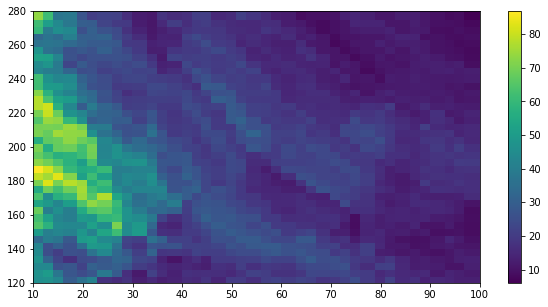

In [186]:
#plt pcolor will take in the x,y values which are the short and long ma
#and we will assign the pnl value results to the given x,y 
plt.subplots(figsize=(10,5))
plt.pcolor(short_ma,long_ma,results_pnl)
plt.colorbar()
plt.show()

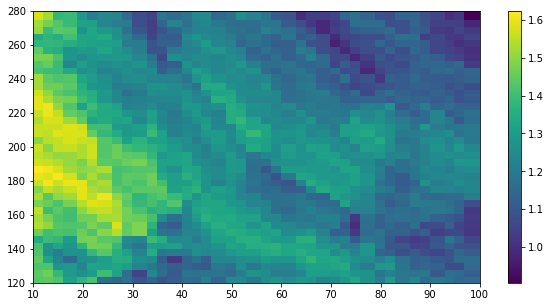

In [187]:
#now we plot the sharpe 
plt.subplots(figsize=(10,5))
plt.pcolor(short_ma,long_ma,results_sharpe)
plt.colorbar()
plt.show()

Looking at the heat map, we can see that the  ma crossover strategy that yields the maximum return and sharpe ratio is below 30 for the short ma and  inbetween 180 and 210 for the long ma. These combinations would yield considerably more returns compared to the combination tested earlier ( shortma=50 , longma=200).

### Quick comparison plot

In [197]:
ma_strategy('BTC-USD',12,185)

 1    793
-1    486
Name: Stance, dtype: int64


(16.597658555481644, 1.1797344939277292)

In [198]:
ticker=data.DataReader('BTC-USD','yahoo',start='01/01/2014',end='01/01/2020')

ticker['short sma']=np.round(ticker['Close'].rolling(window=40).mean(),2)
ticker['long sma']=np.round(ticker['Close'].rolling(window=165).mean(),2)

#create column with moving average spread differen
ticker['short_ma - long_ma']= ticker['short sma']-ticker['long sma']

#set desired number of points as threshold for spread difference and create column containing strategy 'Stance'
X=0
# Y=-50
ticker['Stance']=np.where(ticker['short_ma - long_ma'] > X,1,0)
ticker['Stance']=np.where(ticker['short_ma - long_ma'] < -X,-1,ticker['Stance'])
#remove all the NaN values
ticker=ticker.dropna()
print(ticker['Stance'].value_counts())

#create a column for the log percentage daily returns 
ticker['Market returns']=ticker['Adj Close'].pct_change()
#create a column for the log percentage return for the strategy
ticker['Strategy_returns']=ticker['Market returns']*ticker['Stance']
ticker=ticker.dropna()


#add 1 to daily returns
ticker['Market returns']=ticker['Market returns'].apply(lambda x: x+1)
#add 1 to strategy returns
ticker['Strategy_returns']=ticker['Strategy_returns'].apply(lambda x: x+1)


#buy and hold strategy
ticker['Buy and hold performance']=ticker['Market returns'].cumprod()
# MA crossover strategy
ticker['MA crossover optimised strategy performance']=ticker['Strategy_returns'].cumprod()

 1    1104
-1     666
Name: Stance, dtype: int64


Text(0, 0.5, 'Portfolio performance (hundred %) ')

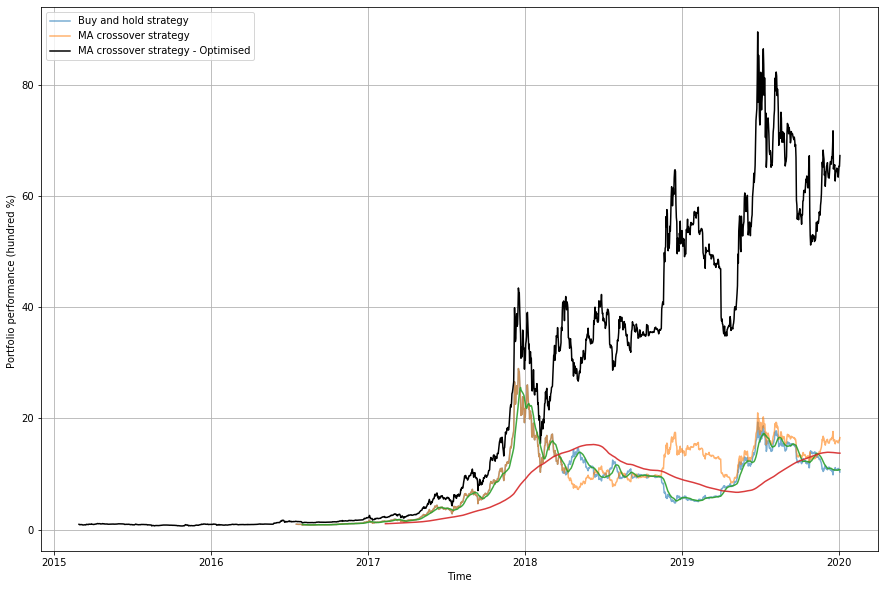

In [199]:
plt.subplots(figsize=(15,10))
#Strategies
plt.plot(ticker_data['Buy and hold returns'],alpha=0.60,label='Buy and hold strategy')
plt.plot(ticker_data['MA crossover strategy returns'],alpha=0.60,label='MA crossover strategy')
plt.plot(ticker['MA crossover optimised strategy performance'], color='black', label='MA crossover strategy - Optimised')

#MA crossovers
plt.plot(ticker_data['Buy and hold returns'].rolling(15).mean(),alpha=0.90,)
plt.plot(ticker_data['Buy and hold returns'].rolling(207).mean(),alpha=0.90)

plt.grid()
plt.legend()

plt.xlabel('Time')
plt.ylabel('Portfolio performance (hundred %) ')

We can clearly see that the optimised MA Crossover strategy beats both the buy and hold and the first MA crossover strategy.

In [200]:
ticker['MA crossover optimised strategy performance'].describe()

count    1769.000000
mean       21.780386
std        24.083820
min         0.654667
25%         1.073907
50%         6.407305
75%        37.562653
max        89.466809
Name: MA crossover optimised strategy performance, dtype: float64

#### Conclusion

In this notebook we have found that simple technical indicator can yield better returns and have better Sharpe ratios in comparison to buy and hold strategies. Through optimising the strategy parameters further, we were able to get much better returns whilst minimizing risk. 

It is important to mention that with the passing of time and new data points the strategy may well start diverging from its optimal parameters calculated therefore fine tuning and updating the parameters may be necessary going forward.